In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm.autonotebook import tqdm
from polar import PolarCode,get_frozen
from reliability_sequence import Reliability_Sequence
from utils import errors_ber,errors_bler
import matplotlib.pyplot as plt
import os

C:\Users\pratyush\AppData\Local\Temp\ipykernel_17516\3055195471.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
n = 5
N = 2**n 
K = 16
snr = 1
batch_size = 1
num_samples = 1000


In [ ]:

def create_data(num_samples, batch_size, n, K, snr,rs):
    msg_bits_list = []
    bpsk_list = []
    codeword_list = []
    corrupted_codeword_list = []

    # Loop to generate data samples
    for i in range(num_samples):
        msg_bits = (torch.rand(K) > 0.5).float()
        bpsk = 1 - 2 * msg_bits

        polar = PolarCode(n, K, rs = rs, Fr=None, use_cuda=False, hard_decision=True)
        codeword = polar.encode(bpsk)
        corrupted_codewords = polar.channel(codeword, snr)

        msg_bits_list.append(msg_bits.cpu().numpy())
        bpsk_list.append(bpsk.cpu().numpy())
        codeword_list.append(codeword.cpu().numpy())
        corrupted_codeword_list.append(corrupted_codewords.cpu().numpy())

    filename = f"polar_dataset_N{2**n}_K{K}_SNR{snr}_bs{batch_size}.npz"
    np.savez(f"polar_dataset_N{2**n}_K{K}_SNR{snr}_bs{batch_size}.npz", msg_bits=msg_bits_list, corrupted_codeword=corrupted_codeword_list,bpsk = bpsk_list,codeword=codeword_list)
    print(f"Dataset saved as {filename}")
    

In [4]:
create_data(num_samples,batch_size,n,K,snr,rs=Reliability_Sequence)

Dataset saved as polar_dataset_N32_K16_SNR1_bs1.npz


In [3]:
df = np.load('data_rs\polar_dataset_N32_K16_SNR1_bs1.npz')

In [7]:

polar = PolarCode(n, K, rs = Reliability_Sequence, use_cuda=False,hard_decision=True)
device = 'cpu'
ber_SC_total=0
bler_SC_total=0
decoded_messages = []
x=10000
for bpsk_bits, corrupted_codeword in tqdm(zip(df['bpsk'][:x], df['corrupted_codeword'][:x]),total=len(df['bpsk'][:x])):
    bpsk_tensor = torch.tensor(bpsk_bits, dtype=torch.float32,device=device)
    corrupted_codeword_tensor = torch.tensor(corrupted_codeword, dtype=torch.float32,device=device)

    SC_llrs, decoded_SC_msg_bits = polar.sc_decode_new(corrupted_codeword_tensor, snr=snr)
    decoded_messages.append(decoded_SC_msg_bits)
    ber_SC = errors_ber(bpsk_tensor,decoded_SC_msg_bits.sign()).item()
    bler_SC = errors_bler(bpsk_tensor,decoded_SC_msg_bits.sign()).item()

    ber_SC_total+=ber_SC
    bler_SC_total+=bler_SC

filename = f"decodedbits_N{2**n}_K{K}_SNR{snr}_bs{batch_size}.npz"
np.savez(f"decodedbits_N{2**n}_K{K}_SNR{snr}_bs{batch_size}.npz", decoded_msg_bits = decoded_messages)

100%|██████████| 1000/1000 [00:55<00:00, 18.14it/s]


In [8]:
ber_SC_total/len(df['msg_bits']),bler_SC_total/len(df['msg_bits'])

(0.1066875, 0.255)

In [4]:
df_decoded= np.load('data_rs\decodedbits_N32_K16_SNR1_bs1.npz')

In [7]:
class PolarDataset(torch.utils.data.Dataset):
    def __init__(self,df,df_decoded):
        polar = PolarCode(n, K, rs = Reliability_Sequence, Fr=None, use_cuda=False, hard_decision=True)
        self.msg_bits = torch.tensor(df['msg_bits'])
        self.bpsk = torch.tensor(df['bpsk'])
        self.corrupted_codeword = torch.tensor(df['corrupted_codeword'])
        self.codeword = torch.tensor(df['codeword'])
        self.decoded_bits = torch.tensor(df_decoded['decoded_msg_bits'])
        encoded_msg_bits_decoded = polar.encode(torch.tensor(df_decoded['decoded_msg_bits']).squeeze(1))
        self.new_data = torch.cat([encoded_msg_bits_decoded.unsqueeze(-1)/2,self.corrupted_codeword.squeeze(1).unsqueeze(-1)],dim=-1)
    def __len__(self):
        return len(self.msg_bits)
    
    def __getitem__(self, idx):
        msg_bits = self.msg_bits[idx]
        bpsk_bits = self.bpsk[idx]
        corrupted_codeword = self.corrupted_codeword[idx]
        codeword = self.codeword[idx]
        new_data = self.new_data[idx]

        return msg_bits,bpsk_bits,corrupted_codeword,codeword,new_data

In [8]:
dataset = PolarDataset(df,df_decoded)

In [22]:
dataloader = torch.utils.data.DataLoader(dataset,batch_size=64,shuffle=True)
msg,bpsk,corrupt,codeword,new = next(iter(dataloader))
# msg[0],bpsk[0],corrupt[0],codeword[0],new[0]

In [23]:
class PolarNet(nn.Module):
    def __init__(self,hidden_channels,K):
        super().__init__()

        self.cnn = nn.Conv2d(1,hidden_channels,kernel_size = (1,2),stride=1)
        # self.fc1 = nn.Linear(hidden_channels, 64)
        self.fc = nn.Linear(hidden_channels*N,K)

    def forward(self,x):
        x = x.unsqueeze(0).unsqueeze(0)
        x = torch.nn.functional.relu(self.cnn(x)) #[1,128,32,1]
        x = x.squeeze(-1) #[1,hidden_channels,32]
        x = x.view(x.shape[0], -1)
        x = self.fc(x)  #logits #[1,K]

        return x

In [24]:
device = 'cuda'
model = PolarNet(hidden_channels=128,K=K).to(device)
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.HingeEmbeddingLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [73]:
def calculate_ber_bler(predictions, targets):
    """ Calculate BER and BLER using errors_ber and errors_bler functions. """
    ber = errors_ber(targets, predictions.sign()).item()
    bler = errors_bler(targets, predictions.sign()).item()
    return ber, bler

In [26]:
num_epochs = 50
patience = 50  # Early stopping patience
best_loss = float('inf')
trigger_times = 0

polar = PolarCode(n, K, rs = Reliability_Sequence, use_cuda=True,hard_decision=True)
loss_values = []
ber_values = []
bler_values=[]
for epoch in range(num_epochs):
    model.train()
    total_loss, total_ber, total_bler = 0, 0, 0

    for msg,bpsk,corrupted_codeword,_,new_data in tqdm(dataloader):

        # SC_llrs, decoded_SC_msg_bits = polar.sc_decode_new(corrupted_codeword_tensor, snr=snr)
        # decoded_bits_encoded = polar.encode(decoded_SC_msg_bits)
        
        optimizer.zero_grad()
        print(corrupted_codeword.shape)
        final_predictions = model(corrupted_codeword.to(device))
        # print(final_predictions.shape)
        bce_loss = criterion(final_predictions, msg)

        loss = bce_loss
        loss.backward()

        optimizer.step()
        
        total_loss += loss.item()
        ber, bler = calculate_ber_bler((torch.sigmoid(final_predictions)>0.5).float(), msg)
        total_ber += ber
        total_bler += bler

    # Compute average loss and error rates
    avg_loss = total_loss / len(dataset)
    avg_ber = total_ber / len(dataset)
    avg_bler = total_bler / len(dataset)

    loss_values.append(avg_loss)
    ber_values.append(avg_ber)
    bler_values.append(avg_bler)

    # Early stopping check
    if avg_loss < best_loss:
        best_loss = avg_loss
        trigger_times = 0
        
        ckpt_path = rf'weights_rs\N_{N}_K_{K}_SNR_{snr}_polarnet'
        os.makedirs(ckpt_path,exist_ok=True)
        torch.save(model.state_dict(), os.path.join(ckpt_path,f'epoch_{epoch}.pth'))
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered!")
            break

    # Logging progress every 3 epochs
    if (epoch + 1) % 3 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, BER: {avg_ber:.4f}, BLER: {avg_bler:.4f}")

print("Training complete.")



  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([64, 1, 32])


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1, 64, 1, 32]

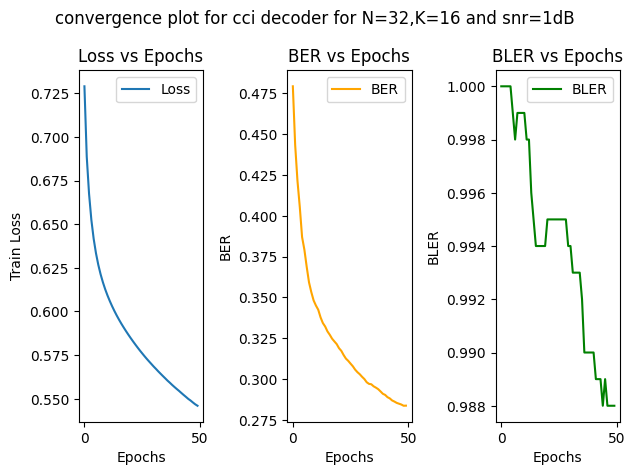

In [78]:
plt.suptitle('convergence plot for cci decoder for N=32,K=16 and snr=1dB')
# Plot Loss vs Epochs
plt.subplot(1, 3, 1)
plt.plot(loss_values, label='Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.legend()

# Plot BER vs Epochs
plt.subplot(1, 3, 2)
plt.plot(ber_values, label='BER', color='orange')
plt.title('BER vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()

# Plot BLER vs Epochs

plt.subplot(1, 3, 3)
plt.plot(bler_values, label='BLER', color='green')
plt.title('BLER vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BLER')
plt.legend()

plt.tight_layout()
plt.show()

In [83]:
ber_total,bler_total = 0,0
test_loader = df['msg_bits'][900:]
count = 0
with torch.no_grad():
    model.eval()
    for msg_bits, data in zip(df['msg_bits'][900:], new_data[900:]):
        count += 1
        msg_tensor = torch.tensor(msg_bits, dtype=torch.float32).to(device)
        data = data.to(device)
        # corrupted_codeword_tensor = torch.tensor(corrupted_codeword, dtype=torch.float32).to(device)

        final_predictions = model(data)
        if (count%20==0):
            print(f'final_predictions {(final_predictions>=0).float()}')
            print(f'msg_tensor {msg_tensor}')
            if((final_predictions>0).float()==msg_tensor).all():
                print('decoded correctly')
            else:
                print('decoded incorrectly')
            print('----------')
        ber,bler = calculate_ber_bler((final_predictions>=0).float(),msg_tensor)
        ber_total += ber
        bler_total += bler
    avg_ber = ber_total / len(test_loader)
    avg_bler = bler_total / len(test_loader)
    print(f"Test Results - BER: {avg_ber:.4f}, BLER: {avg_bler:.4f}")

final_predictions tensor([[1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.]],
       device='cuda:0')
msg_tensor tensor([[1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0.]],
       device='cuda:0')
decoded incorrectly
----------
final_predictions tensor([[1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1.]],
       device='cuda:0')
msg_tensor tensor([[1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.]],
       device='cuda:0')
decoded incorrectly
----------
final_predictions tensor([[1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1.]],
       device='cuda:0')
msg_tensor tensor([[1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1.]],
       device='cuda:0')
decoded incorrectly
----------
final_predictions tensor([[1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1.]],
       device='cuda:0')
msg_tensor tensor([[0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1.]],
       device='cuda:0')

In [77]:
(torch.sigmoid(final_predictions)>0.5).float(),(final_predictions>=0).float(), msg_tensor, data

(tensor([[1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0.]],
        device='cuda:0'),
 tensor([[1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0.]],
        device='cuda:0'),
 tensor([[1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0.]],
        device='cuda:0'),
 tensor([[ 0.5000,  0.5867],
         [ 0.5000, -0.6717],
         [-0.5000, -1.3406],
         [-0.5000,  0.2034],
         [-0.5000, -1.5795],
         [-0.5000, -1.9162],
         [-0.5000, -0.8167],
         [-0.5000, -1.2519],
         [ 0.5000,  0.9523],
         [-0.5000, -1.2641],
         [-0.5000,  0.1596],
         [ 0.5000,  0.6466],
         [ 0.5000,  1.8391],
         [-0.5000, -1.2447],
         [ 0.5000,  1.6245],
         [-0.5000,  0.6077],
         [ 0.5000,  3.0681],
         [ 0.5000, -1.3620],
         [-0.5000, -0.7121],
         [-0.5000, -0.3346],
         [-0.5000, -0.0464],
         [-0.5000,  0.4399],
         [-0.5000, -2.1260],
         [-0.5000, -0.4706]

In [92]:
class PolarNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, K):
        super(PolarNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, K)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # No activation (logits for BCEWithLogitsLoss)
        return x

# Model Initialization
input_dim = 32 + 16  # SC-decoded LLRs + Frozen bit mask
hidden_dim = 128
K = 16  # Number of message bits

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = PolarNet(input_dim, hidden_dim, K).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training Loop
num_epochs = 50
data_len = 1000  # Training samples
frozen_bits_mask = torch.tensor(get_frozen(N,K,rs=Reliability_Sequence), dtype=torch.float32).to(device).unsqueeze(0)  # Frozen bit positions

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_ber, total_bler = 0, 0
    
    for corrupted_codeword, original_msg in tqdm(zip(df['corrupted_codeword'][:data_len], df['msg_bits'][:data_len]), total=data_len):
        corrupted_tensor = torch.tensor(corrupted_codeword, dtype=torch.float32).to(device)
        original_msg_tensor = torch.tensor(original_msg, dtype=torch.float32).to(device)
        
        # SC Decoding
        SC_llrs, decoded_SC_msg_bits = polar.sc_decode_new(corrupted_tensor, snr=snr)
        # SC_llrs = SC_llrs.unsqueeze(0)
        
        # Feature Engineering (Concatenating SC LLRs and Frozen Bit Mask)
        input_features = torch.cat([SC_llrs, frozen_bits_mask], dim=1) # # Concatenation along feature axis
        
        optimizer.zero_grad()
        predictions = model(input_features)  # Shape: [1, K]
        
        loss = criterion(predictions, original_msg_tensor)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        ber, bler = calculate_ber_bler((predictions >= 0).float(), original_msg_tensor.unsqueeze(0))
        total_ber += ber
        total_bler += bler
    
    avg_loss = total_loss / data_len
    avg_ber = total_ber / data_len
    avg_bler = total_bler / data_len
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, BER: {avg_ber:.4f}, BLER: {avg_bler:.4f}")

100%|██████████| 1000/1000 [02:48<00:00,  5.95it/s]


Epoch 1/50, Loss: 1.3814, BER: 0.5026, BLER: 1.0000


100%|██████████| 1000/1000 [02:59<00:00,  5.56it/s]


Epoch 2/50, Loss: 0.6945, BER: 0.5027, BLER: 1.0000


100%|██████████| 1000/1000 [02:58<00:00,  5.61it/s]


Epoch 3/50, Loss: 0.6945, BER: 0.5025, BLER: 1.0000


  4%|▍         | 42/1000 [00:07<02:46,  5.75it/s]


KeyboardInterrupt: 

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm

class NeuralSCDecoder(nn.Module):
    def __init__(self, N, K, hidden_dim=128):
        super(NeuralSCDecoder, self).__init__()
        self.fc1 = nn.Linear(K, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, K)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)  # Output logits
        return x


device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = NeuralSCDecoder(N, K).to(device)
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.HingeEmbeddingLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
num_epochs = 50
ber_list, bler_list = [], []
data_len = len(df['corrupted_codeword'])
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_ber, total_bler = 0, 0
    
    for corrupted_codeword, original_msg in tqdm(zip(df['corrupted_codeword'][:data_len], df['bpsk'][:data_len]), total=data_len):
        corrupted_tensor = torch.tensor(corrupted_codeword, dtype=torch.float32).to(device)
        original_msg_tensor = torch.tensor(original_msg, dtype=torch.float32).to(device)

        # SC Decoding
        SC_llrs, decoded_SC_msg_bits = polar.sc_decode_new(corrupted_tensor, snr=snr)
        SC_llrs = SC_llrs.unsqueeze(0)  # Ensure correct shape

        # print(SC_llrs.shape)
        # print(decoded_SC_msg_bits.shape)
        optimizer.zero_grad()
        predictions = model(decoded_SC_msg_bits)  
        
        loss = criterion(predictions, original_msg_tensor)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        ber, bler = calculate_ber_bler(predictions.sign(), original_msg_tensor.unsqueeze(0))
        total_ber += ber
        total_bler += bler
    
    avg_loss = total_loss / data_len
    avg_ber = total_ber / data_len
    avg_bler = total_bler / data_len
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, BER: {avg_ber:.4f}, BLER: {avg_bler:.4f}")
    
    # Early stopping mechanism
    if avg_loss < best_loss:
        best_loss = avg_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered!")
            break

print("Training complete.")




100%|██████████| 1000/1000 [02:42<00:00,  6.16it/s]


Epoch 1/50, Loss: 0.1571, BER: 0.4926, BLER: 1.0000


100%|██████████| 1000/1000 [02:48<00:00,  5.95it/s]


Epoch 2/50, Loss: -0.8564, BER: 0.4971, BLER: 1.0000


 18%|█▊        | 175/1000 [00:30<02:22,  5.77it/s]


KeyboardInterrupt: 